In [27]:
import torch
from torch.utils import data
from torchvision.transforms import Compose, Normalize, Resize, InterpolationMode
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import numpy as np
import os
# Now, let's define the ECGDataset class and the modified load_data function again.

class ECGDataset(data.Dataset):
    """Represents an optimized abstract HDF5 dataset for ECG."""
    def __init__(self, ecg_path, txt_path, column='deid_t_diagnosis_original'):
        super().__init__()
        
        self.window_size = 2500
        self.fs = 250.0
        self.ecg_path = ecg_path
        # Load the text (diagnosis) dataset from CSV
        self.txt_dset = pd.read_csv(txt_path, usecols=['HashFileName', column], low_memory=False)
        
        # Match the diagnosis based on HashFileName
        self.filename_to_txt = self.txt_dset.dropna(subset=['HashFileName']).set_index('HashFileName')[column].to_dict()

            
    def __len__(self):
        return len(self.ecg_path)
    
    def __getitem__(self, idx):
        '''
        # read data
        data_type, sid, seg_id = self.index_list[index][0].split('_')
        if data_type == 'bwh':
            data_path = 'bwh/hd5/'
        elif data_type == 'mgh':
            data_path = 'mgh/hd5/mgh'
        
        res = h5py.File(os.path.join(self.root_path, data_path, sid+'.hd5'), 'r')
        keys = list(res['partners_ecg_rest'].keys())

        raw_h5 = res['partners_ecg_rest'][keys[int(seg_id)]]
        ecg_data = []

        for lead in self.leads:
            ecg_data.append(decompress_data(raw_h5[lead][()], dtype=raw_h5[lead].attrs['dtype']))
        '''

        hdf5_file = h5py.File(self.ecg_path, 'r')
        #ecg = file['ecg']['2021-10-21T00:00:00'][lead][:]
        
        for k in list(hdf5_file['ecg'].keys()):
            t = hdf5_file['ecg'][k]
            #ecg = hdf5_file['ecg'][k][lead][:]
            metadata,ecg = self.extract_metadata(t)
            
        ecg = np.expand_dims(ecg, axis=0)
        #ecg = np.repeat(ecg, 3, axis=0)  # Replicating channels similar to the reference code
        
        # Fetch the corresponding diagnosis text based on the HDF5 file name
        hdf5_filename = os.path.basename(self.ecg_path).replace('.hd5', '')
        txt = self.filename_to_txt.get(hdf5_filename)  # Default to empty string if not found
        #corresponding_txt = csv_data[csv_data['HashFileName'] == hd5_filename]['deid_t_diagnosis_original'].iloc[0]

        #sample_rate = float(decompress_data(raw_h5['ecgsamplebase_pc'][()], dtype=raw_h5['ecgsamplebase_pc'].attrs['dtype']))
        '''    
        ecg_data = np.array(ecg_data, dtype=np.float)
        ecg_data = self.preprocess(ecg_data, sample_rate)
        ecg_data = torch.tensor(ecg_data, dtype=torch.float)
        '''
        sample = {'ecg': ecg, 'txt': txt, 'meta':metadata}
        
        return sample
        
    def resample_unequal(self, ts, fs_in, fs_out):
        if fs_in == 0:
            return ts
        t = len(ts) / fs_in
        fs_in, fs_out = int(fs_in), int(fs_out)
        if fs_out == fs_in:
            return ts
        if 2*fs_out == fs_in:
            return ts[::2]
        else:
            x_old = np.linspace(0, 1, num=len(ts), endpoint=True)
            x_new = np.linspace(0, 1, num=t*fs_out, endpoint=True)
            y_old = ts
            f = interp1d(x_old, y_old, kind='linear')
            y_new = f(x_new)
            return y_new
            
    def extract_metadata(self, group):
        metadata = {}
        ecg = {}
        for key, value in group.items():
            # Exclude the datasets that represent ECG leads
            #if key not in ["I", "II", "III", "V1", "V2", "V3", "V4", "V5", "V6", "aVF", "aVL", "aVR"]:
            if value.shape == ():  # Check if the dataset is a scalar value
                metadata[key] = value[()]
                
            else:
                ecg[key] = value[:]  # For non-scalar values, get the entire array
               
        return metadata, ecg
    
    def preprocess(self, arr, sample_rate):
        """
        arr has shape (n_channel, n_length)

        """
        out = []
        for tmp in arr:

            # resample
            if sample_rate != self.fs:
                tmp = self.resample_unequal(tmp, sample_rate, self.fs)

            # filter
            # tmp = notch_filter(tmp, self.fs, 60, verbose='ERROR')
            # tmp = filter_data(tmp, self.fs, 0.5, 50, verbose='ERROR')

            out.append(tmp)

        out = np.array(out)
        n_length = out.shape[1]

        if n_length > self.window_size: # crop center window_size for longer
            i_start = (n_length-self.window_size)//2
            i_end = i_start+self.window_size
            out = out[:, i_start:i_end]
        elif n_length < self.window_size: # pad zeros for shorter
            pad_len = np.zeros((self.n_leads, self.window_size-n_length))
            out = np.concatenate([out, pad_len], axis=1)

        return out
        
# Adjusting the load_data function to cater for ECG data
def load_data(ecg_path, txt_path, batch_size=128, column='deid_t_diagnosis_original'): 
    if torch.cuda.is_available():  
        dev = "cuda:0" 
        cuda_available = True
        print('Using CUDA.')
    else:  
        dev = "cpu"  
        cuda_available = False
        print('Using cpu.')
    
    device = torch.device(dev)
    
    if cuda_available: 
        torch.cuda.set_device(device)
    
    torch_dset = ECGDataset(ecg_path=ecg_path,
                            txt_path=txt_path, column=column)
    
    
    data_loader = data.DataLoader(torch_dset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())
    return data_loader, device

# The ECGDataset and load_data functions are now defined.
cxr_filepath = '/home/ubuntu/data/de_111496386_20211021101732_20211021102136.hd5'
txt_filepath = '/home/ubuntu/data/sample.csv'

ECG = load_data(ecg_path=cxr_filepath, txt_path=txt_filepath)
ECG

Using CUDA.


(<torch.utils.data.dataloader.DataLoader at 0x7f95a992ae20>,
 device(type='cuda', index=0))

In [28]:
def visualize_samples_from_dataset(dataset, num_samples=1):
    """Visualize ECG samples from the dataset."""
    for i in range(num_samples):
        sample = dataset[i]
        ecg, txt, meta= sample['ecg'], sample['txt'], sample['meta']
        print(txt)
        # Plot ECG data

        #plt.plot(ecg)
        #plt.title(f"Diagnosis: {txt} | Lead: {lead}")
        #plt.xlabel("Time")
        #plt.ylabel("Amplitude")
        #plt.show()
        '''
        for idx, lead in enumerate(ecg.keys()):
            plt.figure(figsize=(10, 4))
            plt.subplot(len(ecg), 1, idx+1)
            plt.plot(ecg[lead])
            plt.title(f"Diagnosis: {txt} | Lead: {lead}")
            plt.tight_layout()
            plt.xlabel("Time")
            plt.ylabel("Amplitude")
        '''
# Let's visualize the samples again using the optimized dataset class version 6 and the updated visualization function
visualize_samples_from_dataset(ECGDataset(ecg_path=cxr_filepath, txt_path=txt_filepath))


NameError: name 'column' is not defined

In [1]:
import os
import h5py
import numpy as np
import pandas as pd
import torch
from torch.utils import data
from scipy.interpolate import interp1d

# Defining the ECGDataset class and load_data function

class ECGDataset(data.Dataset):
    """Represents an optimized abstract HDF5 dataset for ECG."""
    def __init__(self, ecg_path, txt_path, column='deid_t_diagnosis_original'):
        super().__init__()
        
        self.window_size = 2500
        self.fs = 250.0
        self.leads = ['I', 'II', 'III', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'aVF', 'aVL', 'aVR']
        self.n_leads = len(self.leads)

        self.ecg_path = ecg_path
        # Load the diagnosis dataset from CSV
        self.txt_dset = pd.read_csv(txt_path, usecols=['HashFileName', column], low_memory=False)
        
        # Match the diagnosis based on HashFileName
        self.filename_to_txt = self.txt_dset.dropna(subset=['HashFileName']).set_index('HashFileName')[column].to_dict()

    def __len__(self):
        return len(self.leads)
    
    def __getitem__(self, idx):
        lead = self.leads[idx]
        hdf5_file = h5py.File(self.ecg_path, 'r')
        
        ecg_data = []
        for k in list(hdf5_file['ecg'].keys()):
            ecg = hdf5_file['ecg'][k][lead][:]
            metadata = self.extract_metadata(hdf5_file['ecg'][k])
            ecg_data.append(ecg)
        
        ecg = np.concatenate(ecg_data, axis=0)
        ecg = np.expand_dims(ecg, axis=0)
        
        # Fetch the corresponding diagnosis text based on the HDF5 file name
        hdf5_filename = os.path.basename(self.ecg_path).replace('.hd5', '')
        txt = self.filename_to_txt.get(hdf5_filename, " ")  # Default to empty string if not found
        
        sample = {'ecg': ecg, 'txt': txt, 'lead': lead}
        
        return sample
        
    def resample_unequal(self, ts, fs_in, fs_out):
        if fs_in == 0:
            return ts
        t = len(ts) / fs_in
        fs_in, fs_out = int(fs_in), int(fs_out)
        if fs_out == fs_in:
            return ts
        if 2*fs_out == fs_in:
            return ts[::2]
        else:
            x_old = np.linspace(0, 1, num=len(ts), endpoint=True)
            x_new = np.linspace(0, 1, num=t*fs_out, endpoint=True)
            y_old = ts
            f = interp1d(x_old, y_old, kind='linear')
            y_new = f(x_new)
            return y_new
            
    def extract_metadata(self, group):
        metadata = {}
        for key, value in group.items():
            # Check if the dataset is a scalar value
            if value.shape == ():  
                metadata[key] = value[()]
        return metadata
    
    def preprocess(self, arr, sample_rate):
        """
        arr has shape (n_channel, n_length)
        """
        out = []
        for tmp in arr:
            # resample
            if sample_rate != self.fs:
                tmp = self.resample_unequal(tmp, sample_rate, self.fs)
            out.append(tmp)
        out = np.array(out)
        n_length = out.shape[1]

        if n_length > self.window_size:  # crop center window_size for longer
            i_start = (n_length-self.window_size)//2
            i_end = i_start+self.window_size
            out = out[:, i_start:i_end]
        elif n_length < self.window_size:  # pad zeros for shorter
            pad_len = np.zeros((self.n_leads, self.window_size-n_length))
            out = np.concatenate([out, pad_len], axis=1)

        return out


def load_data(ecg_path, txt_path, batch_size=128, column='deid_t_diagnosis_original'): 
    if torch.cuda.is_available():  
        dev = "cuda:0" 
        cuda_available = True
        print('Using CUDA.')
    else:  
        dev = "cpu"  
        cuda_available = False
        print('Using CPU.')
    
    device = torch.device(dev)
    
    if cuda_available: 
        torch.cuda.set_device(device)
    
    torch_dset = ECGDataset(ecg_path=ecg_path, txt_path=txt_path, column=column)
    data_loader = data.DataLoader(torch_dset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())
    
    return data_loader, device
    
cxr_filepath = '/home/ubuntu/data/de_111496386_20211021101732_20211021102136.hd5'
txt_filepath = '/home/ubuntu/data/sample.csv'
# Now, creating an instance of the ECGDataset and extracting the first few samples
ecg_dataset = ECGDataset(ecg_path=cxr_filepath, 
                          txt_path=txt_filepath, 
                          column='deid_t_diagnosis_original')

# Extracting the first few samples from the dataset
samples = [ecg_dataset[i] for i in range(min(5, len(ecg_dataset)))]

samples

[{'ecg': array([[-175, -175, -175, ...,  -87,  -92,  -92]], dtype=int16),
  'txt': ' ',
  'lead': 'I'},
 {'ecg': array([[-9, -9, -9, ..., 82, 78, 82]], dtype=int16),
  'txt': ' ',
  'lead': 'II'},
 {'ecg': array([[165, 165, 165, ..., 170, 170, 175]], dtype=int16),
  'txt': ' ',
  'lead': 'III'},
 {'ecg': array([[390, 390, 390, ..., 268, 248, 234]], dtype=int16),
  'txt': ' ',
  'lead': 'V1'},
 {'ecg': array([[185, 185, 185, ..., 146, 141, 136]], dtype=int16),
  'txt': ' ',
  'lead': 'V2'}]

In [1]:
import torch
from torch.utils.data import Dataset
import torch
from torch.utils import data
import matplotlib.pyplot as plt
import h5py
import pandas as pd
import numpy as np
import os

class ECGDataset(Dataset):
    def __init__(self, txt_path, ecg_path):
        self.window_size = 2500
        self.fs = 250.0
        self.data = pd.read_csv(txt_path)
        # Drop rows where HashFileName or deid_t_diagnosis_original is NaN
        self.data = self.data.dropna(subset=['HashFileName', 'deid_t_diagnosis_original'])
        self.ecg_path = ecg_path
        self.leads = ['I', 'II', 'III', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'aVF', 'aVL', 'aVR']

    def __len__(self):
        return len(self.data)

    def resample_unequal(self, ts, fs_in, fs_out):
        if fs_in == 0:
            return ts
        t = len(ts) / fs_in
        fs_in, fs_out = int(fs_in), int(fs_out)
        if fs_out == fs_in:
            return ts
        if 2*fs_out == fs_in:
            return ts[::2]
        else:
            x_old = np.linspace(0, 1, num=len(ts), endpoint=True)
            x_new = np.linspace(0, 1, num=t*fs_out, endpoint=True)
            y_old = ts
            f = interp1d(x_old, y_old, kind='linear')
            y_new = f(x_new)
            return y_new
    
    def preprocess(self, arr, sample_rate):
        """
        arr has shape (n_channel, n_length)

        """
        out = []
        for tmp in arr:

            # resample
            if sample_rate != self.fs:
                tmp = self.resample_unequal(tmp, sample_rate, self.fs)

            # filter
            # tmp = notch_filter(tmp, self.fs, 60, verbose='ERROR')
            # tmp = filter_data(tmp, self.fs, 0.5, 50, verbose='ERROR')

            out.append(tmp)

        out = np.array(out)
        n_length = out.shape[1]

        if n_length > self.window_size: # crop center window_size for longer
            i_start = (n_length-self.window_size)//2
            i_end = i_start+self.window_size
            out = out[:, i_start:i_end]
        elif n_length < self.window_size: # pad zeros for shorter
            pad_len = np.zeros((self.n_leads, self.window_size-n_length))
            out = np.concatenate([out, pad_len], axis=1)

        return out
        
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        hash_file_name = row['HashFileName']
        diagnosis = row['deid_t_diagnosis_original']




        s_dirs = [f"S{i:04d}" for i in range(1, 5)] # Assuming there are only 4 'S' directories, modify as needed
        year_dirs = [str(i) for i in range(1987, 2024)] # Assuming years range from 1980 to 2020
        month_dirs = [f"{i:02}" for i in range(1, 13)]

        # Iterate over all possible combinations to find the file
        file_found = False
        for s_dir in s_dirs:
            for year_dir in year_dirs:
                for month_dir in month_dirs:
                    file_path = f"{self.ecg_path}/{s_dir}/{year_dir}/{month_dir}/{hash_file_name}"
                    if os.path.exists(file_path):
                        hd5_file = h5py.File(file_path, "r")
                        file_found = True
                        break
                if file_found:
                    break
            if file_found:
                break
        #hd5_file = h5py.File(f"{self.ecg_path}/{hash_file_name}", "r")

        if not file_found:
            raise ValueError(f"File {self.ecg_path}/{s_dir}/{year_dir}/{month_dir}/{hash_file_name} not found in the directory structure.")
            print(idx)
        # Load the corresponding hd5 file for ECG data
        for k in list(hd5_file['ecg'].keys()):
            ecg_data_list = [torch.tensor(hd5_file['ecg'][k][lead][:]) for lead in self.leads]
            ecg_data = torch.stack(ecg_data_list, dim=0)
            sample_rate = float(hd5_file['ecg'][k]['ecgsamplebase_pc'][()])
        
    
        ecg_data = np.array(ecg_data, dtype=np.float64)
        ecg_data = self.preprocess(ecg_data, sample_rate)
        ecg_data = torch.tensor(ecg_data, dtype=torch.float)

        sample = {'ecg': ecg_data, 'txt': diagnosis,'file':file_path }
        return sample

def load_data(ecg_path, txt_path, batch_size=128, column='deid_t_diagnosis_original'): 
    if torch.cuda.is_available():  
        dev = "cuda:0" 
        cuda_available = True
        print('Using CUDA.')
    else:  
        dev = "cpu"  
        cuda_available = False
        print('Using CPU.')
    
    device = torch.device(dev)
    
    if cuda_available: 
        torch.cuda.set_device(device)
    
    torch_dset = ECGDataset(ecg_path=ecg_path, txt_path=txt_path)
    data_loader = data.DataLoader(torch_dset, batch_size=batch_size, shuffle=True, num_workers=os.cpu_count())
    
    return data_loader, device
    
# Testing the dataset with the provided files
cxr_filepath = '/home/ubuntu/data/ecg'
txt_filepath = '/home/ubuntu/data/combined_ecg_diagnosis.csv'
dataset = ECGDataset(txt_filepath, cxr_filepath)
sample = dataset[0]
ECGdataloader,dev = load_data(txt_path = txt_filepath, ecg_path = cxr_filepath)
#print(sample)
print(ECGdataloader,dev)

Using CUDA.
<torch.utils.data.dataloader.DataLoader object at 0x7fb3f0ce9220> cuda:0


In [2]:
dataset[2]

{'ecg': tensor([[-102., -102., -102.,  ..., -117., -126., -126.],
         [ -92.,  -87.,  -97.,  ..., -136., -136., -136.],
         [   9.,   14.,    4.,  ...,  -19.,   -9.,   -9.],
         ...,
         [ -41.,  -36.,  -46.,  ...,  -78.,  -73.,  -73.],
         [ -56.,  -58.,  -53.,  ...,  -48.,  -58.,  -58.],
         [  97.,   95.,  100.,  ...,  126.,  131.,  131.]]),
 'txt': 'NORMAL SINUS RHYTHM NORMAL ECG WHEN COMPARED WITH ECG OF ',
 'file': '/home/ubuntu/data/ecg/S0003/2010/02/de_115828429_20111219012630_20111219114122.hd5'}

In [6]:
df = pd.read_csv('/home/ubuntu/data/combined_ecg_diagnosis.csv')
df.iloc[0].tolist()

[0,
 111888311,
 'de_111888311_20120607205223_20120608195341.hd5',
 'NORMAL SINUS RHYTHM|NORMAL ECG|WHEN COMPARED WITH ECG OF||NO SIGNIFICANT CHANGE WAS FOUND',
 'NORMAL SINUS RHYTHM NORMAL ECG WHEN COMPARED WITH ECG OF  NO SIGNIFICANT CHANGE WAS FOUND']

In [11]:
df.shape

(10650681, 5)

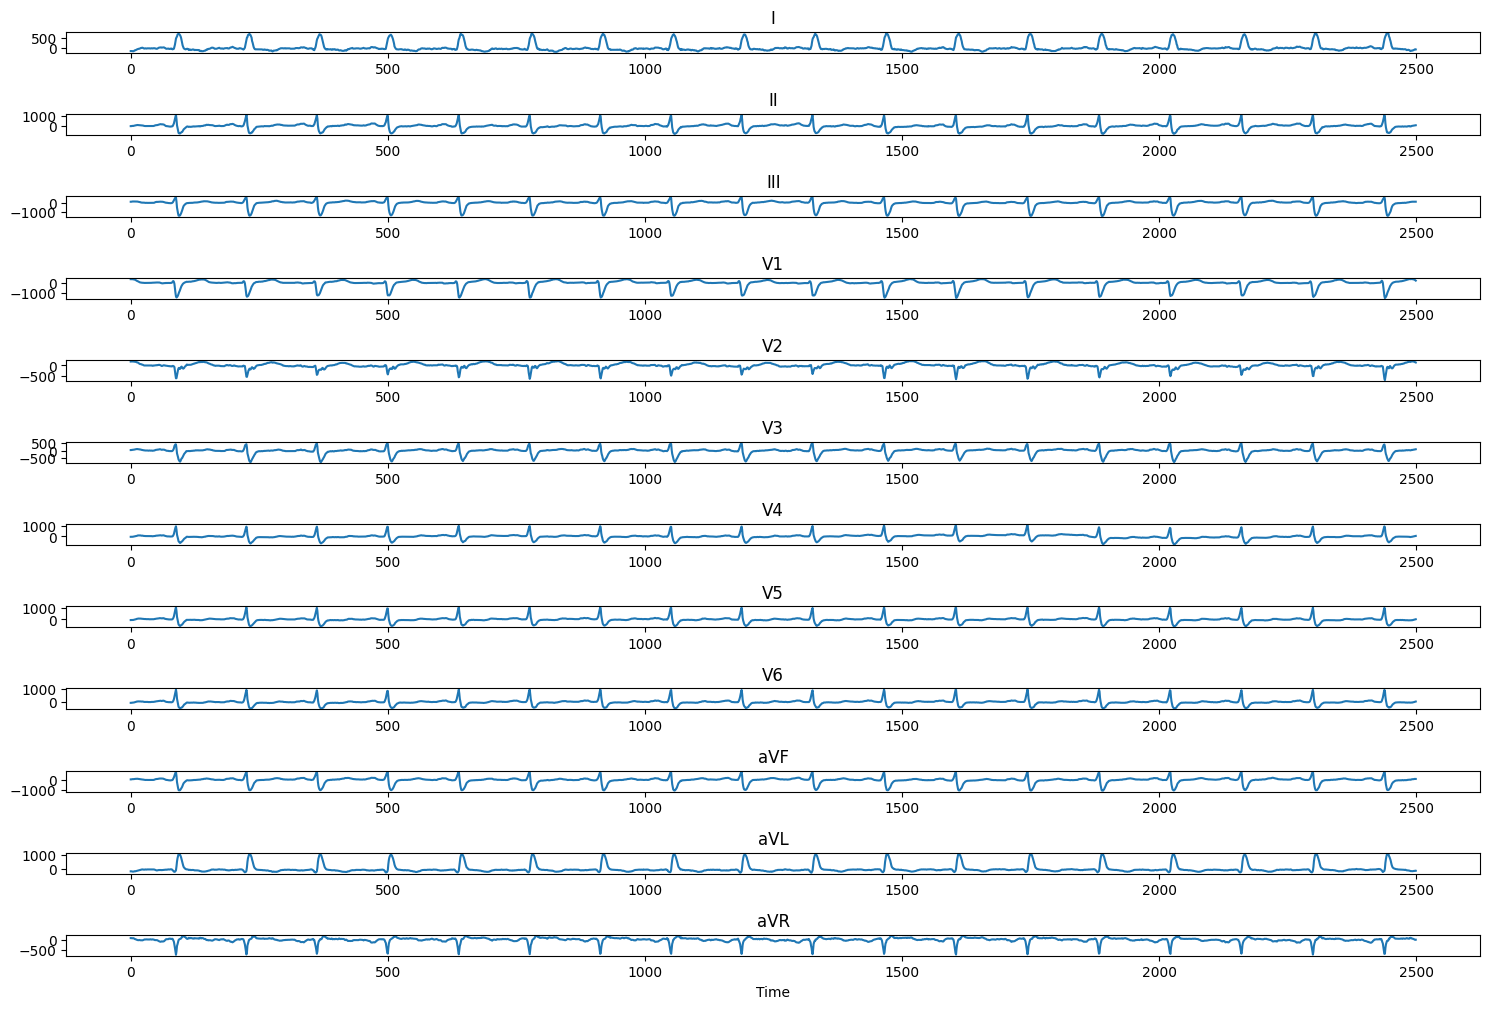

In [15]:
import matplotlib.pyplot as plt

def plot_ecg_data(ecg_data, leads):
    plt.figure(figsize=(15, 10))
    for i, lead in enumerate(leads):
        plt.subplot(len(leads), 1, i+1)
        plt.plot(ecg_data[i].numpy())
        plt.title(lead)
        plt.tight_layout()
    
    plt.xlabel("Time")
    plt.show()

plot_ecg_data(sample_ecg, dataset.leads)
